# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Model

In [4]:
fc1_units = 512  #128 ## 64
fc2_units = 256  #64 #32
fc3_units = 64
#fc4 is 16 by default
lr_actor = 1e-3
lr_critic = 1e-3
buffer_size = int(1e6)
batch_size = 64 # 128
Gamma = 0.999
tau = 0.001


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np




def layer_init(self):
    in_w = self.weight.data.size()[0]
    lim = 1./(np.sqrt(in_w))
    return (-lim,lim)


class Actor(nn.Module):
    ## Module is base class for all neural networks
    
    """ Define the class for Actor netorks to be used in the model
    
    Parameters:
    state_size, action_size, seed,fc1_units, fc2_units 
    all int.
    
    """
    def __init__(self, state_size, action_size, seed,fc1_units = fc1_units , fc2_units = fc2_units, fc3_units = fc3_units):        
        super(Actor,self).__init__()
        ## just writing super() also enough    
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,16)
        self.fc5 = nn.Linear(16,action_size)
        self.seed = torch.manual_seed(seed)
        self.reset_parameters()
        
    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        x =torch.tanh(self.fc5(x))
        return x
    
    def reset_parameters(self):
        
        self.fc1.weight.data.uniform_(*layer_init(self.fc1))
        self.fc2.weight.data.uniform_(*layer_init(self.fc2))
        self.fc3.weight.data.uniform_(*layer_init(self.fc3))
        self.fc4.weight.data.uniform_(*layer_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3,3e-3)
        ### also try just using the reset_parameters()method of layers      
    
    
class Critic(nn.Module):
    """
    Define the class for Critic netorks to be used in the model
    
    Parameters:
    state_size, action_size, seed,fc1_units, fc2_units 
    all int.
    
    """
    
    def __init__(self, state_size, action_size, seed,fc1_units = fc1_units, fc2_units = fc2_units , fc3_units = fc3_units):
        super(Critic,self).__init__()
        ## just writing super() also enough  
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,16)
        self.fc5 = nn.Linear(16,1)
        
        self.seed = torch.manual_seed(seed)
        self.reset_parameters()
        
    def forward(self, state, action):
        
        xst = F.relu(self.fc1(state))
        x =torch.cat((xst, action), dim = 1) ## concatenate along dimension 1 (columns)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def reset_parameters(self):
        
        self.fc1.weight.data.uniform_(*layer_init(self.fc1))
        self.fc2.weight.data.uniform_(*layer_init(self.fc2))
        self.fc3.weight.data.uniform_(*layer_init(self.fc3))
        self.fc4.weight.data.uniform_(*layer_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3,3e-3)
        ### also try just using the reset_parameters()method of layers      
    
    
        

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
from collections import namedtuple, deque

import numpy as np

import random




device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.int_noise = copy.copy(self.mu) ## internal noise

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.int_noise
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.int_noise = x + dx
        return self.int_noise

class Replay_Buffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
from collections import namedtuple, deque

import numpy as np

import random





device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Agent():
    
    def __init__(self, n_agents, state_size, action_size, random_seed):
        
        self.n_agents = n_agents
        self.state_size = state_size
        self.action_size = action_size
        
        # Actor networks local and target
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = lr_actor)
        
        ## Critic networks, local and target
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = lr_critic)
        
        self.noise = OUNoise((n_agents,action_size), random_seed)
        
        self.memory = Replay_Buffer(action_size, buffer_size, batch_size, random_seed)
        
    ## based on the random state generated by the environment, our agent will generate 
    ## an action, by passing the state thru the actor_local network
    
    def act(self,state, add_noise = True):
        
        state = torch.from_numpy(state).float().to(device) # convert state from numpy array to a tensor
        
        self.actor_local.eval() ## put network in evaluation mode, no trainig
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy() # 
            #get action, push data to cpu and convert to numpy array, for the gym env 
            
        self.actor_local.train()
        ## put the network in trainig mode for learn part
        
        if add_noise:
            action += self.noise.sample()
            action = np.clip(action, -1,1)
        return action
    
    ## The action generated by the actor_local network will be passed to the env.step() function
    ## to generate next_state, rewards, done.. The agent will then add these to the memory as experiences
    ## and if we have enough experiences(>128),  the agent will sample and learn from them
    
    def step(self, state, action, reward, next_state, done):
        
        for i in range(self.n_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
        
        #self.memory.add(state, action, reward, next_state, done)
        
        if len(self.memory) > batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, Gamma)
            
    
    def learn(self, experiences, Gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        ### Get Q_target for next_states to compute Q_target for current state
        
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        Q_targets = rewards + (Gamma * Q_targets_next * (1-dones))
        
        ### Compute the actual Q_target based on current critic_local network
        
        Q_expecteds = self.critic_local(states, actions)
        
        Q_loss = F.mse_loss(Q_expecteds, Q_targets)
        
        self.critic_optimizer.zero_grad()
        Q_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        ### We want to train the actor_local such that it maximizes the value Q
        
        actions_pred = self.actor_local(states)
        Q_value = - self.critic_local(states, actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        Q_value.backward()
        self.actor_optimizer.step()
        
        ### soft update target params
        
        self.soft_update( self.actor_local, self.actor_target, tau)
        self.soft_update( self.critic_local, self.critic_target, tau)       
    
    def soft_update(self, local_model, target_model, tau):
        
        for target_params,local_params in zip(target_model.parameters(), local_model.parameters()):
            target_params.data.copy_( tau * local_params.data + (1-tau) * target_params.data)
    
    def reset(self):
        self.noise.reset()
    
            
            

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [9]:
fc1_units = 512 #512  #128 ## 64
fc2_units = 256 #256  #64 #32
fc3_units = 64
#fc4 is 16 by default
lr_actor = 1e-4
lr_critic = 1e-4
buffer_size = int(1e6)
batch_size = 128 # 128
Gamma = 0.99
tau = 0.001


In [10]:
agent = Agent(n_agents = 20,state_size = 33, action_size = 4, random_seed = 2)


env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

In [11]:
from collections import deque
n_agents = 20


def cont_control(n_episodes = 1000,  print_every = 100 ):
    
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1,n_episodes+1):
        
        total_r = np.zeros(n_agents)
        #total_rewards = 0
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        statesA = env_info.vector_observations
        #state = env_info.vector_observations[0]
        #for t in range(max_t):
        while True:
            
            actionsA = agent.act(statesA)
            env_info = env.step(actionsA)[brain_name]
            next_statesA = env_info.vector_observations
            #next_state, reward, done,_ = env.step(action)
            rewardsA = env_info.rewards
            donesA = env_info.local_done            
            
            agent.step(statesA, actionsA, rewardsA, next_statesA, donesA)
            statesA = next_statesA
            total_r += rewardsA
            if np.any(donesA):
                break
        
        scores.append(total_r)
        scores_deque.append(total_r)
        print('\r Episode:{} \t Average Score: {:.2f} \t Average of last 100 episodes: {:.2f}'\
              .format(i_episode, np.mean(scores), np.mean(scores_deque)), end = "")
        #print(' Episode:{} \t Average Score: {}'.format(i_episode, np.mean(scores_deque)))
        #if i_episode % print_every == 0:
            
            #print('\n Episode:{} \t Average Score: {:.2f}\n'.format(i_episode, np.mean(scores_deque)), end='')
            
        if np.mean(scores_deque) >=30:
            torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            print('\n Environment Solved in {} episodes, Average score:{}'.format( (i_episode - 100), np.mean(scores_deque)), end='' )
            #torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
            #torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            break
            
    
    return scores

                
                
            
            
            
            
    
    
    
    

In [12]:
scores = cont_control()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


 Episode:105 	 Average Score: 28.73 	 Average of last 100 episodes: 30.13
 Environment Solved in 5 episodes, Average score:30.127139326605946

The output above shows the average of last 100 episodes from Episode:5 to Episode:105 which is +30.13

In [13]:
len(scores)


105

## Plot all 20 agents' scores

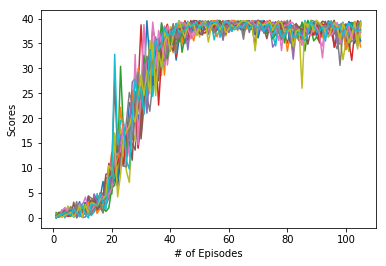

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot( range(1,len(scores)+1), scores)
plt.xlabel('# of Episodes')
plt.ylabel('Scores')
plt.show()

In [17]:
score_ar = np.asarray(scores)

In [18]:
score_ar.shape

(105, 20)

## Mean of 20 agents' scores

In [19]:
score_agent = np.mean(score_ar, axis = 1)

In [20]:
score_agent.shape

(105,)

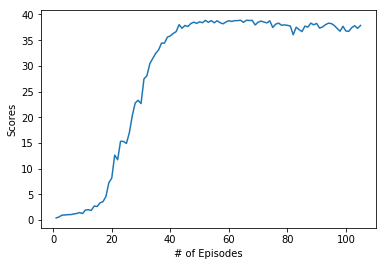

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot( range(1,len(score_agent)+1), score_agent)
plt.xlabel('# of Episodes')
plt.ylabel('Scores')
plt.show()

As we can see the model is quiet stable. The score of +30 was achieved in less than 40 episodes and the algorithm hasn't crashed even after twice the number of episodes.

### Now evaluate our trained Agent's Actor and Critic Models on the 20-agent environment.

In [25]:
for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(n_agents)               
    
    while True:
        actions = agent.act(states, add_noise=False)                    
        
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score))) 

Episode: 	0 	Score: 	38.55
Episode: 	1 	Score: 	39.07
Episode: 	2 	Score: 	38.53


Very impressive and consistent results where in each episode the Agent's score was over 30.